In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

# Load the full scan

In [2]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19506/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [18]:
quantile_corr = 0.6

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
 Izero_pump_scan, Izero_unpump_scan, correlation, Energy_eV) = \
XAS_scan_1diode(fc.selected, detector_XAS, detector_Izero, quantile_corr)



/sf/alvra/data/p19506/raw/scan_info/058_XAS_ZnO_com_5ps_001.json

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 1001 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1002 -> 0% loss
complete channels: 1 / 3 -> 67% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 498 pump and 498 unpump shots
(191,) shots out of (498,) survived
Step 141 of 141: Processed run_004340
correlation Diode (all shots) = 0.7235208491516552


<IPython.core.display.Javascript object>


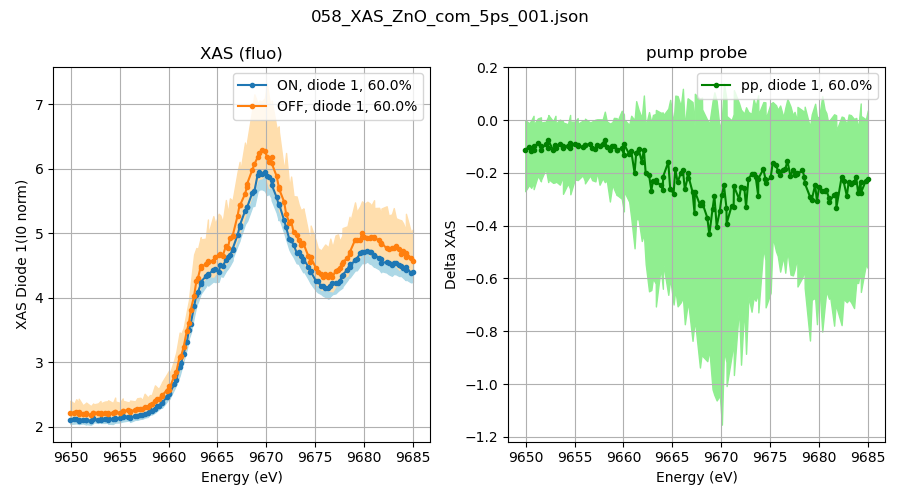

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(Energy_eV, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Energy_eV, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(Energy_eV, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


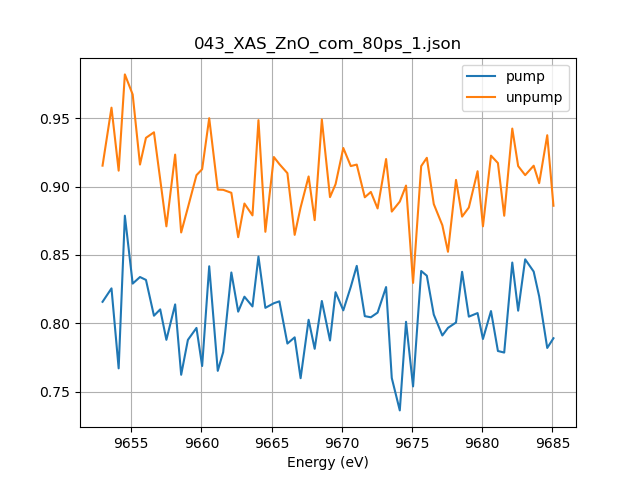

In [11]:
plt.figure()
plt.title(fc.selected_filename)
#plt.plot(Energy_eV, correlation)
plt.plot(Energy_eV, Izero_pump_scan, label = 'pump')
plt.plot(Energy_eV, Izero_unpump_scan, label = 'unpump')
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
#plt.ylabel('Correlation')
plt.grid()
plt.show()

## Check correlation for a certain energy point

In [20]:
chosen_energy = 9670

detector_XAS = channel_diode_1
detector_Izero = channel_Izero117

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

print ('Energy = {} eV'.format(Energy_eV[index_energy]))

(193,) shots out of (487,) survived
Energy = 9670.079500150647 eV


<IPython.core.display.Javascript object>


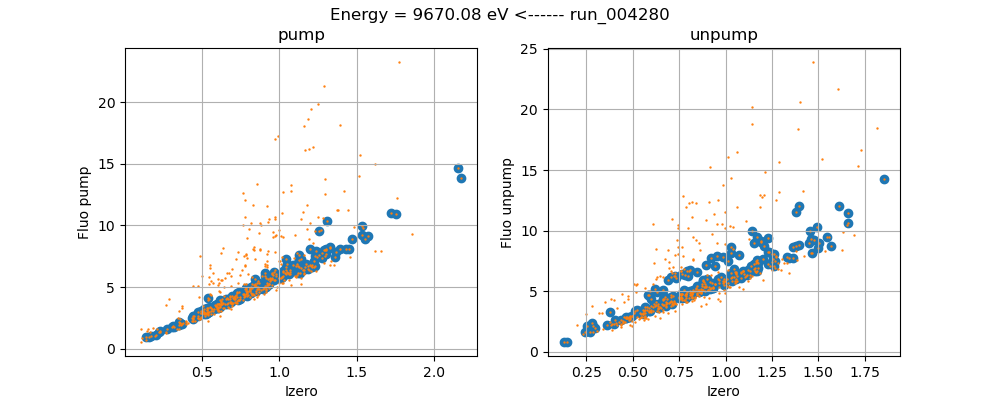

In [21]:
plt.figure(figsize=(10,4))
plt.suptitle('Energy = {:.2f} eV <------ {}'.format(Energy_eV[index_energy], scan.files[index_energy][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump_filter, Fluo_pump_filter)
plt.scatter(Izero_pump, Fluo_pump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter)
plt.scatter(Izero_unpump, Fluo_unpump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


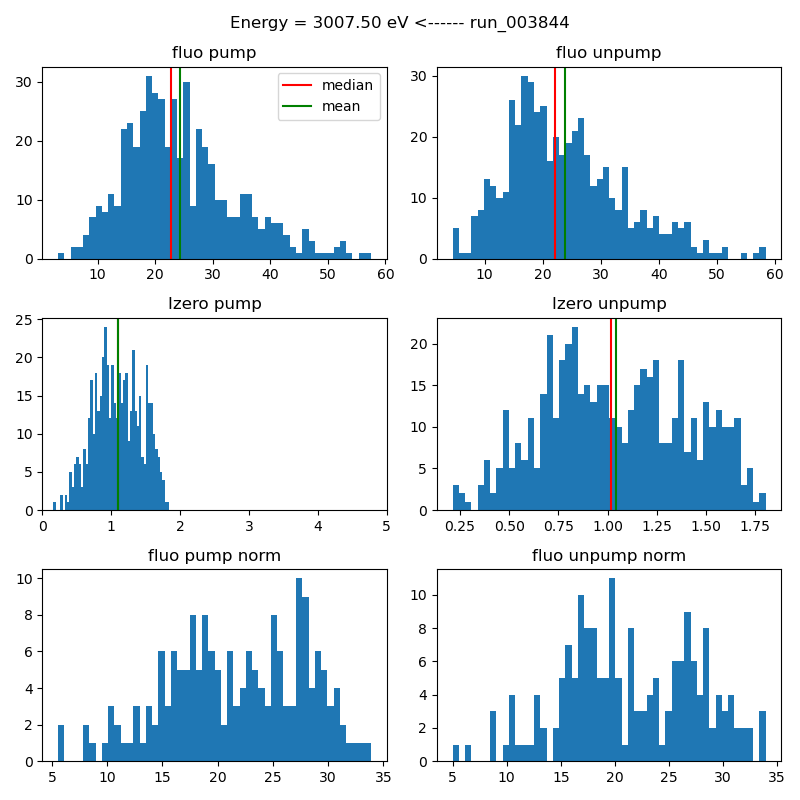

In [22]:
plt.figure(figsize=(8,8))
plt.suptitle('Energy = {:.2f} eV <------ {}'.format(Energy_eV[index_energy], scan.files[index_energy][1].split('/')[-1].split('.')[0]))

plt.subplot(321)
plt.title('fluo pump')
plt.hist(Fluo_pump, bins = 50)
plt.axvline(x=np.median(Fluo_pump), color ='r',label='median')
plt.axvline(x=np.mean(Fluo_pump), color ='g', label = 'mean')
plt.legend(loc='best')

plt.subplot(322)
plt.title('fluo unpump')
plt.hist(Fluo_unpump, bins = 50)
plt.axvline(x=np.median(Fluo_unpump), color ='r')
plt.axvline(x=np.mean(Fluo_unpump), color ='g')

plt.subplot(323)
plt.title('Izero pump')
plt.hist(Izero_pump, bins = 50)
plt.axvline(x=np.median(Izero_pump), color ='r')
plt.axvline(x=np.mean(Izero_pump), color ='g')
plt.xlim(0,5)

plt.subplot(324)
plt.title('Izero unpump')
plt.hist(Izero_unpump, bins = 50)
plt.axvline(x=np.median(Izero_unpump), color ='r')
plt.axvline(x=np.mean(Izero_unpump), color ='g')

plt.subplot(325)
plt.title('fluo pump norm')
plt.hist(Fluo_pump_filter, bins = 50)
#plt.axvline(x=qnt_low_pump, color = 'black')
#plt.axvline(x=qnt_high_pump, color = 'black')
#plt.xlim(0,10)

plt.subplot(326)
plt.title('fluo unpump norm')
plt.hist(Fluo_unpump_filter, bins = 50)
#plt.axvline(x=qnt_low_pump, color = 'black')
#plt.axvline(x=qnt_high_pump, color = 'black')
#plt.xlim(0,10)


plt.tight_layout()
plt.show()

## Load files in a loop

In [37]:
datafiles = []
for file in glob('/sf/alvra/data/p19262/raw/scan_info/'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:2]
patch

['/sf/alvra/data/p19506/raw/scan_info/043_XAS_ZnO_com_80ps_1.json',
 '/sf/alvra/data/p19506/raw/scan_info/044_XAS_ZnO_com_80ps_0.json']

In [3]:
quantile_corr = 0.4

detector_XAS = channel_diode_1
detector_Izero = channel_Izero117

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode_pump_all = []
DataDiode_unpump_all = []
Pump_probe_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    Energy_eV = scan.readbacks
    
    DataDiode_pump = []
    DataDiode_unpump = []
    Pump_probe_Diode = []
    
    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, _, _, _, Energy_eV) = \
        XAS_scan_1diode(json_file, detector_XAS, detector_Izero, quantile_corr)        
        
    DataDiode_pump_all.append(DataDiode_pump)
    DataDiode_unpump_all.append(DataDiode_unpump)
    Pump_probe_all.append(Pump_probe_Diode)    

DataDiode_pump_all = np.array(DataDiode_pump_all)
DataDiode_unpump_all = np.array(DataDiode_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)


/sf/alvra/data/p19506/raw/scan_info/044_XAS_ZnO_com_80ps_0.json

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY  999 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 1002 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 498 pump and 498 unpump shots
(81,) shots out of (498,) survived
Step 65 of 65: Processed run_003418
correlation Diode (all shots) = 0.9687411353498918


NameError: name 'Energy_eV_all' is not defined

<IPython.core.display.Javascript object>


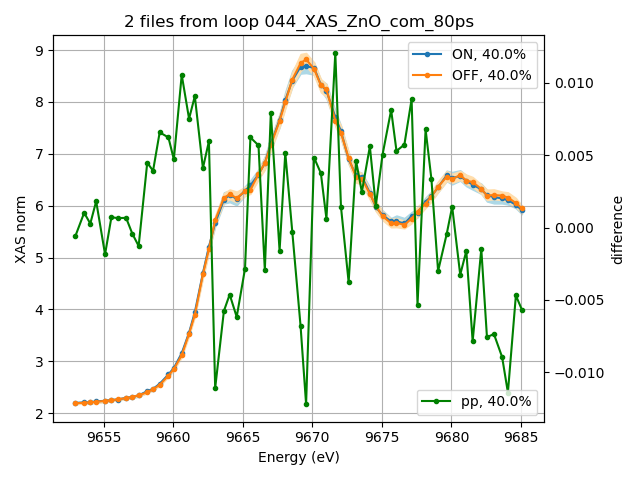

In [9]:
XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = np.mean(DataDiode_pump_all, axis=0)[:,1]
err_high_pump = np.mean(DataDiode_pump_all, axis=0)[:,2]
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,1]
err_high_unpump = np.mean(DataDiode_unpump_all, axis =0)[:,2]
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]

fig, ax1 = plt.subplots()
plt.title('{} files from loop {}'.format(len(patch), json_file.split('/')[-1][:-7]))

ax2 = ax1.twinx()
ax1.plot(Energy_eV, XAS_pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS_unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')


ax2.plot(Energy_eV, XAS_pump_probe/XAS_pump, label='pp, {}%'.format(quantile_corr*100),marker='.', color='g')

ax1.legend(loc='best')
ax2.legend(loc='lower right')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('XAS norm')
ax2.set_ylabel('difference')
ax1.grid()
plt.tight_layout()
plt.show()

## cell to export data

In [ ]:
import pandas as pd
DIR_save = "/das/work/p18/p18956/UserFolder/"
file2save = DIR_save + scan_name + ".txt"
pd.DataFrame({
    'Energy_eV' : Energy_eV,
    'pump_probe': Pump_probe,
    'signal_on' : DataFluo_pump,
    'signal_off' : DataFluo_unpump,
}).to_csv(file2save,index=False)